# Computer Vision & Deep Learning - Generative AI & Visual Synthesis

# Exercise 4: Convolutional Neural Networks

**Due on 24.05.2024., 10:00**

## Important notes

- Email: Frequently check your email address registered for Moodle. All notifications regarding the course will be sent via Moodle.
- Moodle: Please use the Moodle platform and post your questions to the forum. They will be answered by us or your fellow students.
-  Submission: Put your code and potentially other materials inside a single ZIP file. If you use jupyter notebooks, please always create a PDF file and include it in your ZIP file. The final submission should therefore be a **single zip** file with a **PDF of your code** and the **original code** inside. The ZIP file should contain your surname and your matriculation number (Surname-MatriculationNumber.zip). Submissions that fail to follow the naming convention will not be graded!

In [159]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T


RESULTS_DIR = 'results'

In [2]:
# Create results directory
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

---
## Task 1:  Convolutions Revisited

Compute the output of a 2D-convolution operation with 3
different filters of kernel size 2 ×2 defined by the following weight matrices and
biases

In [3]:
# 1. define dummy input image
img = torch.tensor([[[
        [1., 0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1.]]]])

1. Using s = 1 (stride) and p = 0 (padding), calculate by hand the output of the convolution operation followed by the ReLU activation function


TODO

2. Think about and describe how the input image patch, the convolution kernel,
and the ReLU activation function interact, and how you can avoid manual
computation and directly infer the output for each patch


TODO

3. Now repeat (a) with s = 2. Please only report the final outputs, not the
intermediate ones before the activation.

TODO

4. What might be the purpose of using s = 2? What other operation can be
used instead for the same purpose? Hint: Think about compression.

TODO

5. Please derive the general formula to compute the output size of a convolution
operation (size of the feature map), depending on the kernel size, the stride,
and padding. It is sufficient to derive it for the 1D case

TODO

---
## Task 2: Receptive Field
The receptive field of a neuron in a Convolutional Neural Network (CNN) is the
size of the image region that is connected to the neuron

1. Suppose that we have a CNN with 3 convolutional layers with a kernel size
of 3 ×3 and s = 1. Calculate the receptive field of a neuron after the last
convolutional layer.

TODO

2. Suppose that we have a CNN with 2 convolutional layers with a kernel size
of 4 ×4 and s = 2. Calculate the receptive field of a neuron after the last
convolutional layer.

TODO

3. Based on your findings, how is the depth related to the receptive field of a
CNN? 

TODO

When keeping the depth fixed, can you infer any strategies to still
increase the receptive field of a CNN?

TODO

---
## Task 3: Convolutional Neural Networks

In the previous exercise, we already used the PyTorch framework to train a neural network classifier. Now, we want to move on to a more complex dataset than MNIST and use a Convolutional Neural Network for classification.

### Task 3.1: Dataset

In [4]:
# Load CIFAR10 dataset
dataset = torchvision.datasets.CIFAR10(root='data/', download=True)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

Files already downloaded and verified


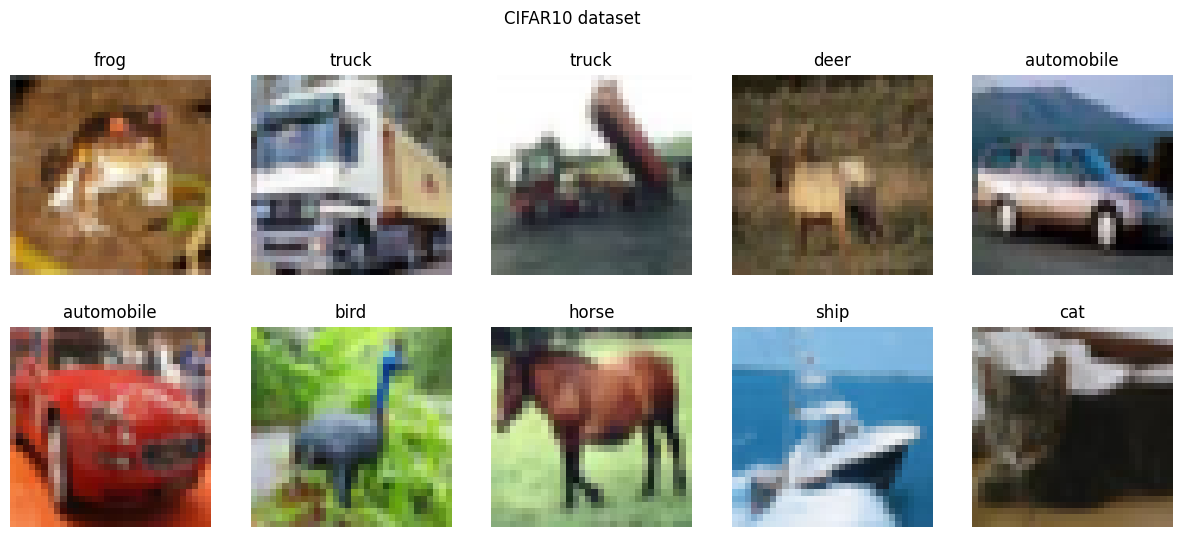

In [5]:
# Plot 10 images from each class
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    img, label = dataset[i]
    ax = axs[i // 5, i % 5]
    ax.imshow(img)
    ax.set_title(dataset.classes[label])
    ax.axis('off')

# set title
fig.suptitle('CIFAR10 dataset')

# save the plot
plt.savefig(f'{RESULTS_DIR}/cifar10.png')

In [6]:
# define data transformations
transform = T.Compose([
    T.Resize((32,32)),
    T.ToTensor(),
    #T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# apply data transformations to the training and testing sets
train_dataset = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


### 3.2 Network

In [7]:
class Net(nn.Module):
    def __init__(self, normalization=False):
        super(Net, self).__init__()
        self.normalization = normalization
        # convolution block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), padding=0, stride=1)
        self.norm1 = nn.BatchNorm2d(num_features=6)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), padding=0, stride=1)
        self.norm2 = nn.BatchNorm2d(num_features=16)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        # fully connected block
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # convolution block
        x = self.conv1(x)
        if self.normalization:
            x = self.norm1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        if self.normalization:
            x = self.norm2(x)
        x = F.relu(x)
        x = self.pool2(x)
        # flatten the signal    
        x = x.view(x.size(0), -1)
        # fully connected block
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
    
        return x

### 3.3 Training

In [8]:
def train(model, criterion, optimizer, train_loader, test_loader, num_epochs=10, use_gpu=False):

    # move the model to the device (CPU or GPU)
    if use_gpu and torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()

    # create empty lists to store accuracy for each epoch
    train_acc = []
    test_acc = []

    # iterate over epochs
    for epoch in tqdm(range(num_epochs), desc='Training', unit='epoch'):

        # set the model to training mode
        model.train()

        running_loss = 0.0
        running_correct = 0.0
        for step, [example, label] in enumerate(train_loader):
            
            # move the data to the device (CPU or GPU)
            if use_gpu and torch.cuda.is_available():
                example = example.cuda()
                label = label.cuda()

            # zero the parameter gradients - prevent accumulation of gradients
            optimizer.zero_grad()

            # forward pass
            prediction = model(example)
            loss = criterion(prediction, label)

            # backward pass
            loss.backward()
            optimizer.step()

            # calculate accuracy on the current training batch
            _, predicted = torch.max(prediction.data, 1)
            running_correct += (predicted == label).sum().item()
            running_loss += loss.item()

        # calculate training accuracy for the current epoch
        train_acc.append(running_correct / len(train_loader.dataset))

        # validate the model
        model.eval()
        correct = 0
        total = 0

        # set the model to evaluation mode
        for idx, [test_example, test_label] in enumerate(tqdm(test_loader, desc='Testing', unit='batch')):
            
            # move the data to the device (CPU or GPU)
            if use_gpu and torch.cuda.is_available():
                test_example = test_example.cuda()
                test_label = test_label.cuda()

            # forward pass
            test_prediction = model(test_example)
            loss = criterion(test_prediction, test_label)

            # get the predicted class label
            _, predicted = torch.max(test_prediction.data, 1)
            total += test_label.size(0)
            correct += (predicted == test_label).sum().item()

        # calculate test accuracy for the current epoch
        test_acc.append(correct / total)

        # print the loss and accuracy
        print("\n *** Summary: Epoch [{} / {}]  Train Accuracy: {}  Test Accuracy: {}***".format(epoch + 1, num_epochs, train_acc[-1], test_acc[-1]))
        torch.save(model.state_dict(), '{}/ConvNet{}.ckpt'.format(RESULTS_DIR, epoch + 1))

    return train_acc, test_acc


In [9]:
# train the model
model = Net(normalization=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_acc, test_acc = train(model, criterion, optimizer, train_loader, test_loader, num_epochs=3, use_gpu=False)

Training:  33%|███▎      | 1/3 [00:43<01:27, 43.76s/epoch]


 *** Summary: Epoch [1 / 3]  Train Accuracy: 0.44736  Test Accuracy: 0.5488***


Training:  67%|██████▋   | 2/3 [01:30<00:45, 45.64s/epoch]


 *** Summary: Epoch [2 / 3]  Train Accuracy: 0.56122  Test Accuracy: 0.5755***


Training: 100%|██████████| 3/3 [02:14<00:00, 44.90s/epoch]


 *** Summary: Epoch [3 / 3]  Train Accuracy: 0.59796  Test Accuracy: 0.6079***


Plot how the accuracy (i.e. percentage of correctly classified images) of your model evolves for both, the training- and test-set of CIFAR10. Please make sure to add meaningful axis labels for your plot (y-axis as
the accuracy and x-axis as the epoch number).

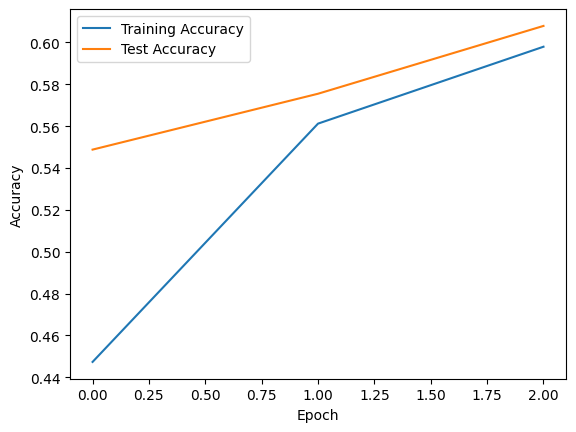

In [10]:
def plot_accuracy(train_acc, test_acc):
    # plot accuracy versus epoch number
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# plot the accuracy
plot_accuracy(train_acc, test_acc)

What do you observe in the accuracy plot, in particular if you compare the train and test accuracy? Do you have an explanation for that?

*TODO...*

### 3.4 Augmentation

Please apply random horizontal flipping, random cropping with padding=4, and ColorJitter to the CIFAR10 images and visualize a few pairs of augmented images against their original.

In [11]:
# define the transformations
transform_aug = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# load the dataset and apply the transformations
train_dataset_aug = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transform_aug)
test_dataset_aug = torchvision.datasets.CIFAR10(root='data/', train=False, download=True, transform=transform_aug)

train_loader_aug = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader_aug = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


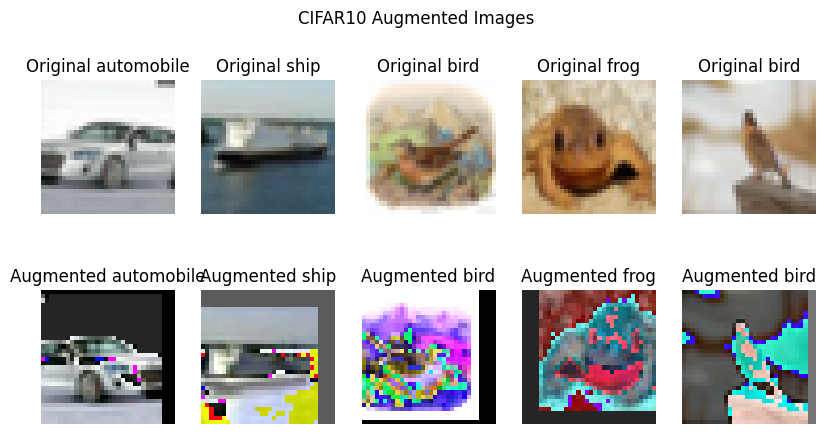

In [12]:
# visualize a few pairs of augmented images against their original images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    # get a random sample from the training set
    index = torch.randint(len(train_dataset), size=(1,))
    img_aug, label_aug = train_dataset_aug[index]
    img, label = train_dataset[index]

    # convert image back from tensor
    if isinstance(img, torch.Tensor) or isinstance(img_aug, torch.Tensor):
        img = img.numpy()
        img_aug = img_aug.numpy()

    # convert images
    img_original = T.ToPILImage()(np.transpose(img, (1, 2, 0)))
    img_augmented = T.ToPILImage()(np.transpose(img_aug, (1, 2, 0)))
    class_name = train_dataset.classes[label]

    # plot the original image
    ax = axs[0, i]
    ax.imshow(img_original)
    ax.set_title(f'Original {class_name}')
    ax.axis('off')

    # plot the augmented image
    ax = axs[1, i]
    ax.imshow(img_augmented)
    ax.set_title(f'Augmented {class_name}')
    ax.axis('off')

# set title
fig.suptitle('CIFAR10 Augmented Images')

# save the plot
plt.savefig(f'{RESULTS_DIR}/augmented_images.png')

Train your model using the same setup as above, however, with additional normalization (normalize your input images channel-wise using μ = 0.5 and σ = 0.5) and data augmentation.

In [13]:
# train the model
model = Net(normalization=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_acc, test_acc = train(model, criterion, optimizer, train_loader_aug, test_loader_aug, num_epochs=3, use_gpu=False)

Training:  33%|███▎      | 1/3 [00:45<01:31, 45.74s/epoch]


 *** Summary: Epoch [1 / 3]  Train Accuracy: 0.46366  Test Accuracy: 0.5325***


Training:  67%|██████▋   | 2/3 [01:26<00:42, 42.74s/epoch]


 *** Summary: Epoch [2 / 3]  Train Accuracy: 0.56106  Test Accuracy: 0.5578***


Training: 100%|██████████| 3/3 [02:08<00:00, 42.78s/epoch]


 *** Summary: Epoch [3 / 3]  Train Accuracy: 0.60398  Test Accuracy: 0.575***


Plot the accuracy of this model and the one you trained before over time. Make sure to use proper axis labels and a meaningful legend.

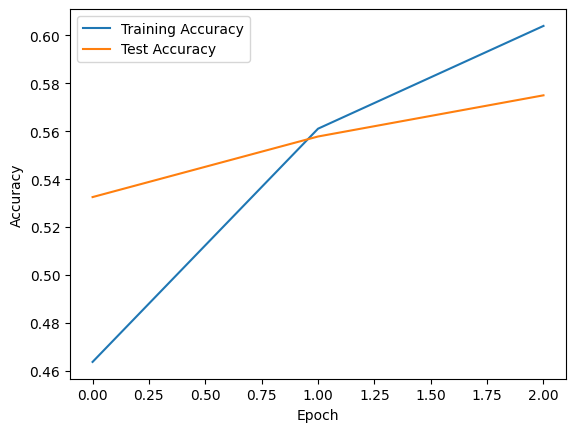

In [14]:
# plot the accuracy
plot_accuracy(train_acc, test_acc)

Based on your results, provide a brief discussion of why the extra normalization and augmentation improves/harms the performance of your model.

*TODO...*

---
## Task 4: Activation and Saliency Maps

In this task, we will try to visualize what CNNs learn by means of the activation
map, which is considered to be more informative than just visualizing e.g. the
kernel weights.

### 4.1 Instantiate a pre-traind ResNet18

In [247]:
from torchvision.models import resnet18

# 1. instantiate a pre-trained ResNet18
model = resnet18(pretrained=True)
# set the model to evaluation mode
model.eval()

# print the model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.2 Intermediate Activation Maps

In [248]:
import torchvision.utils as V
import matplotlib.pyplot as plt

# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the provided image and get the output
img = Image.open('./data/pug.jpg')
transform = T.Compose([T.ToTensor()])
X = transform(img).unsqueeze(dim=0).to(device)

# extract intermediate activations
# e.g., the out after the first conv in the first residual block and 
# the out after the last conv in the last residual block
activations = []
def get_activation(name):
    def hook(model, input, output):
        activations.append(output)
    return hook

# register the hooks
with torch.no_grad():
    model.layer1[0].conv1.register_forward_hook(get_activation('layer1'))
    model.layer3[0].conv1.register_forward_hook(get_activation('layer3'))

    # perform the forward pass
    output = model(X)

# remove the hooks
model.layer1[0].conv1.register_forward_hook(None)
model.layer3[0].conv1.register_forward_hook(None)

# print the shape of the intermediate activations
print(activations[0].shape)
print(activations[1].shape)

torch.Size([1, 64, 206, 259])
torch.Size([1, 256, 52, 65])


### 4.3 Visualize the Activation Maps

torch.Size([52, 65])
torch.Size([52, 65])


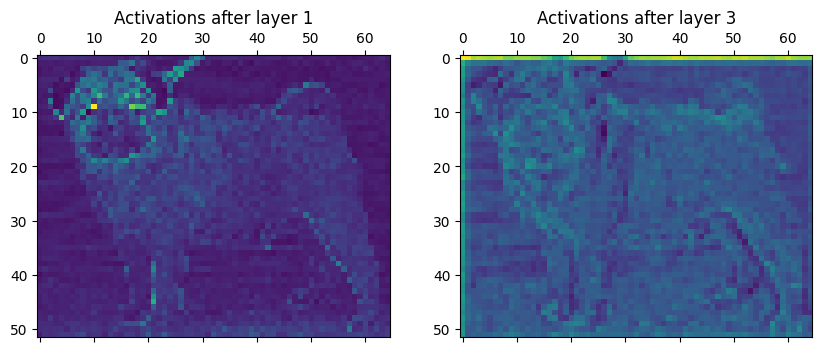

In [249]:
# Interpolate the activations to have the same spatial resolution
act1 = F.interpolate(activations[0], size=(activations[1].shape[2], activations[1].shape[3]), mode='bilinear')
act2 = F.interpolate(activations[1], size=(activations[1].shape[2], activations[1].shape[3]), mode='bilinear')

# Compute the mean of the first 10 channels of the activations
heatmap1 = torch.mean(act1[:, :10], dim=1).squeeze()
heatmap2 = torch.mean(act2[:, :10], dim=1).squeeze()

# print the shape of the heatmaps
print(heatmap1.shape)
print(heatmap2.shape)

# Normalize the heatmap
heatmap1 /= torch.max(heatmap1)
heatmap2 /= torch.max(heatmap2)

# Plot the heatmaps
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].matshow(heatmap1.cpu().numpy())
axs[0].set_title('Activations after layer 1')
axs[1].matshow(heatmap2.cpu().numpy())
axs[1].set_title('Activations after layer 3')

# save the plot
plt.savefig(f'{RESULTS_DIR}/heatmaps.png')
plt.show()

### 4.4 Plot Image and Activation Map

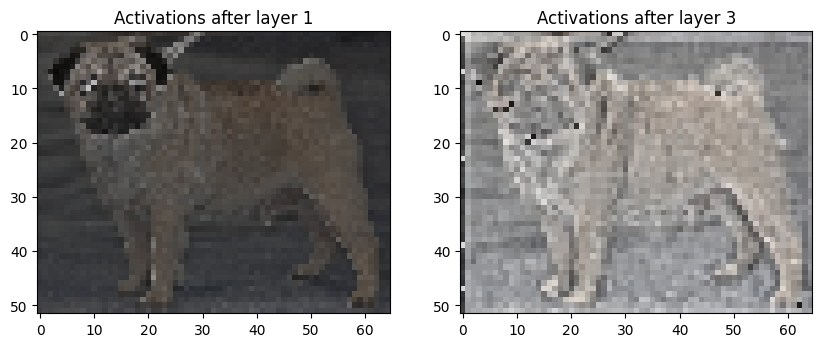

In [250]:
import matplotlib.cm as cm
import matplotlib.colors as colors


# resize the heatmap to have the same spatial resolution as the original image
heatmap1 = Image.fromarray((heatmap1 * 255).byte().numpy())
heatmap2 = Image.fromarray((heatmap2 * 255).byte().numpy())
img = img.resize((heatmap1.size[0], heatmap1.size[1]))

# convert the heatmap to RGB format
heatmap1 = np.array(heatmap1)
heatmap2 = np.array(heatmap2)
heatmap1 = np.concatenate([heatmap1[:, :, np.newaxis]] * 3, axis=2)
heatmap2 = np.concatenate([heatmap2[:, :, np.newaxis]] * 3, axis=2)

# superimpose the heatmap on the original image
alpha = 0.7
beta = 1 - alpha
superimposed_img1 = cv2.addWeighted(np.array(img), beta, np.array(heatmap1), alpha, 0)
superimposed_img2 = cv2.addWeighted(np.array(img), beta, np.array(heatmap2), alpha, 0)

# plot the superimposed image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(superimposed_img1)
axs[0].set_title('Activations after layer 1')
axs[1].imshow(superimposed_img2)
axs[1].set_title('Activations after layer 3')

# save the plot
plt.savefig(f'{RESULTS_DIR}/superimposed.png')
plt.show()

### 4.5 Saliency Map
Introduced in: *Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps*

In [251]:
# illustrate how gather() works
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

# load the images
names = ['catdog_243.png', 'catdog_243.png', 'snake_56.png', 'spider_72.png']

X = [np.array(Image.open(name).convert('RGB')) for name in names]
y = [int(s.rsplit('_')[1].rsplit('.')[0]) for s in names]

# intentionally change the label to a wrong one
y[1] = 285

def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Lambda(lambda x: x[None]),  # equivalent to unsqueeze()
    ])
    return transform(img)

tensor([[-1.2439, -0.6237,  0.1374,  1.1537,  0.8075],
        [ 2.4834,  0.3913,  1.1661, -0.9046, -1.3787],
        [-0.5311, -1.2542,  0.9417, -0.5158,  0.3374],
        [-0.5929,  0.3257,  0.0102, -1.0875,  1.3772]])
tensor([1, 2, 1, 3])
tensor([-0.6237,  1.1661, -1.2542, -1.0875])


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Work Disk Janina Mattes/DEV/University/GAI/GAI-Visual-Synthesis/04_exercise/catdog_243.png'

#### a) Complete the saliency map function.

In [ ]:
def saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = X.clone().detach()
    X_var.requires_grad = True
    y_var = y.clone().detach()
    saliency = None

    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    
    # TODO

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

#### b) Visualize the original images together with the saliency maps.

Visualize the original image with the saliency maps together and provide a short discussion on why different ground truth labels with even the same input image would yield different saliency maps, for instance, the catdog_243.png image with y = 243 (bull mastiff) and y = 285 (Egyptian cat).

In [ ]:
# Please use the same pre-trained network from the previous task for this task
model = None

# if you finished the task 3.1 and defined your model, then this function should run flawlessly
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)
    # Compute saliency maps for images in X
    saliency = saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = len(X)
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title('ground truth label set to {}'.format(y[i]))
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(20, 10)
    plt.show()

show_saliency_maps(X, y)

---